In [1]:
## Automate this analysis 
import os
import polars as pl

base_dir = "/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/simulated/10x3p_sc/invalid_reads"
invalid_types = ["concat_2x", "concat_2x_rev_comp", "concat_3x", 
                 "fwd_fwd_rev", "fwd_rev_fwd", "fwd_rev_rev",
                 "rev_fwd_fwd", "rev_fwd_rev", "rev_rev_fwd"]

for invalid_type in invalid_types:
    invalid_annots = pl.read_parquet(os.path.join(base_dir, invalid_type, "CRF/annotations_invalid.parquet"), columns = ["ReadName", "reason"])
    invalid_reads_reasons = invalid_annots.group_by(["reason"]).agg(pl.count().alias("count")).with_columns((pl.col("count") / pl.col("count").sum()).alias("percentage")).sort("percentage", descending=True)

    concatenated_reads = invalid_reads_reasons.filter(pl.col("reason").str.contains("concatenated reads"))
    concatenated_reads_w_subreads = concatenated_reads.with_columns([pl.col("reason").str.extract(r"x(\d+)", 1).cast(pl.UInt32).alias("x_factor"),(pl.col("count") * pl.col("reason").str.extract(r"x(\d+)", 1).cast(pl.UInt32)).alias("adjusted_count")])
    concatenated_reads_w_subreads.write_csv(os.path.join(base_dir, f"{invalid_type}_reasons_CRF.tsv"), separator="\t")


/tmp/ipykernel_1164676/3888162393.py:12: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  invalid_reads_reasons = invalid_annots.group_by(["reason"]).agg(pl.count().alias("count")).with_columns((pl.col("count") / pl.col("count").sum()).alias("percentage")).sort("percentage", descending=True)


In [2]:
## If a tool's capability to decipher the concatenated reads is bu correctly splitting them into individual subreads, 
## how many would we end up with using the tools that can do it?

## Tranquillyzer

tranquillyzer_total_reads_arr = []

for invalid_type in invalid_types:
    concatenated_reads_w_subreads = pl.read_csv(os.path.join(base_dir, f"{invalid_type}_reasons_CRF.tsv"), separator="\t")
    if invalid_type == "concat_2x":
        invalid_type = "fwd_fwd"
    elif invalid_type == "concat_2x_rev_comp":
        invalid_type = "fwd_rev"
    tranquillyzer_total_reads_arr.append((invalid_type, concatenated_reads_w_subreads.select(pl.sum("adjusted_count")).item()))

tranquillyzer_total_reads_arr_df = pl.DataFrame(tranquillyzer_total_reads_arr, ["type", "tranquillyzer_total_reads"])

print(tranquillyzer_total_reads_arr_df)


shape: (9, 2)
┌─────────────┬───────────────────────────┐
│ type        ┆ tranquillyzer_total_reads │
│ ---         ┆ ---                       │
│ str         ┆ i64                       │
╞═════════════╪═══════════════════════════╡
│ fwd_fwd     ┆ 384808                    │
│ fwd_rev     ┆ 399138                    │
│ concat_3x   ┆ 569836                    │
│ fwd_fwd_rev ┆ 583101                    │
│ fwd_rev_fwd ┆ 577837                    │
│ fwd_rev_rev ┆ 583166                    │
│ rev_fwd_fwd ┆ 561430                    │
│ rev_fwd_rev ┆ 576557                    │
│ rev_rev_fwd ┆ 562450                    │
└─────────────┴───────────────────────────┘


/varidata/research/projects/shen/tools/ayush/mambaforge/envs/tranquilizer/lib/python3.10/functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return dispatch(args[0].__class__)(*args, **kw)


In [3]:
## Sicelore's total reads with adpater and TSO after splitting

sicelore_total_reads_arr = [("fwd_fwd", 185908, 400000), ("fwd_rev", 102305, 400000),
                           ("fwd_fwd_fwd", 235860, 600000), ("fwd_fwd_rev", 132174, 600000),
                           ("fwd_rev_fwd", 180152, 600000), ("fwd_rev_rev", 133652, 600000),
                           ("rev_fwd_fwd", 252094, 600000), ("rev_fwd_rev", 185040, 600000), 
                           ("rev_rev_fwd", 254716, 600000)]
sicelore_total_reads_arr_df = pl.DataFrame(sicelore_total_reads_arr, ["type", "sicelore_total_reads", "expected_total_reads"])

sicelore_total_reads_arr_df = sicelore_total_reads_arr_df.with_columns(
    (pl.col("sicelore_total_reads") / pl.col("expected_total_reads")).alias("sicelore_percentage")
)
print(sicelore_total_reads_arr_df)

shape: (9, 4)
┌─────────────┬──────────────────────┬──────────────────────┬─────────────────────┐
│ type        ┆ sicelore_total_reads ┆ expected_total_reads ┆ sicelore_percentage │
│ ---         ┆ ---                  ┆ ---                  ┆ ---                 │
│ str         ┆ i64                  ┆ i64                  ┆ f64                 │
╞═════════════╪══════════════════════╪══════════════════════╪═════════════════════╡
│ fwd_fwd     ┆ 185908               ┆ 400000               ┆ 0.46477             │
│ fwd_rev     ┆ 102305               ┆ 400000               ┆ 0.2557625           │
│ fwd_fwd_fwd ┆ 235860               ┆ 600000               ┆ 0.3931              │
│ fwd_fwd_rev ┆ 132174               ┆ 600000               ┆ 0.22029             │
│ fwd_rev_fwd ┆ 180152               ┆ 600000               ┆ 0.300253            │
│ fwd_rev_rev ┆ 133652               ┆ 600000               ┆ 0.222753            │
│ rev_fwd_fwd ┆ 252094               ┆ 600000               ┆ 

In [4]:
## wf-single-cells total full-length reads

wfsc_metrics = pl.read_csv("/varidata/research/projects/shen/projects/2025_03_12_tranquilizer_benchmarking/wf_single_cell/METRICS.txt", separator="\t")
wfsc_total_reads_df = wfsc_metrics.filter(pl.col("SAMPLE").is_in(invalid_types))

wfsc_total_reads_df = wfsc_total_reads_df.with_columns(type=pl.col("SAMPLE").replace(["concat_2x", "concat_2x_rev_comp"], 
                                                                   ["fwd_fwd", "fwd_rev"]))
wfsc_total_reads_df = wfsc_total_reads_df.select(["full_len_reads", "type"])
wfsc_total_reads_df = wfsc_total_reads_df.rename({"full_len_reads" : "wf-single-cell_total_reads"})

print(wfsc_metrics)
print(wfsc_total_reads_df)

shape: (31, 7)
┌──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ SAMPLE       ┆ DURATION(hr ┆ full_len_re ┆ non_full_le ┆ reads_w_val ┆ Duration(se ┆ max_rss(GB) │
│ ---          ┆ :min:sec)   ┆ ads         ┆ n_reads     ┆ id_barcodes ┆ cond)       ┆ ---         │
│ str          ┆ ---         ┆ ---         ┆ ---         ┆ ---         ┆ ---         ┆ f64         │
│              ┆ str         ┆ i64         ┆ i64         ┆ i64         ┆ i64         ┆             │
╞══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 5_mil        ┆ 00:08:40    ┆ 3243194     ┆ 1756830     ┆ 854858      ┆ 520         ┆ 14.5        │
│ 5_mil_2      ┆ 00:09:23    ┆ 3243187     ┆ 1756835     ┆ 854858      ┆ 563         ┆ 14.5        │
│ 5_mil_3      ┆ 00:08:36    ┆ 3243188     ┆ 1756836     ┆ 854855      ┆ 516         ┆ 14.5        │
│ 25_mil       ┆ 00:23:50    ┆ 16224283    ┆ 8775814     ┆ 4282794     ┆ 143

In [5]:
## Combined

all_tools_total_reads_df = sicelore_total_reads_arr_df.join(tranquillyzer_total_reads_arr_df, left_on = ["type"], right_on = ["type"], how="inner")
all_tools_total_reads_df = all_tools_total_reads_df.with_columns(
    (pl.col("tranquillyzer_total_reads") / pl.col("expected_total_reads")).alias("tranquillyzer_percentage")
)

all_tools_total_reads_df = all_tools_total_reads_df.join(wfsc_total_reads_df, left_on = ["type"], right_on = ["type"], how="inner")
all_tools_total_reads_df = all_tools_total_reads_df.with_columns(
    (pl.col("wf-single-cell_total_reads") / pl.col("expected_total_reads")).alias("wf-single-cell_percentage")
)

print(all_tools_total_reads_df)

shape: (8, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ type       ┆ sicelore_t ┆ expected_t ┆ sicelore_ ┆ tranquill ┆ tranquill ┆ wf-single ┆ wf-single │
│ ---        ┆ otal_reads ┆ otal_reads ┆ percentag ┆ yzer_tota ┆ yzer_perc ┆ -cell_tot ┆ -cell_per │
│ str        ┆ ---        ┆ ---        ┆ e         ┆ l_reads   ┆ entage    ┆ al_reads  ┆ centage   │
│            ┆ i64        ┆ i64        ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆ f64       ┆ i64       ┆ f64       ┆ i64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ fwd_fwd    ┆ 185908     ┆ 400000     ┆ 0.46477   ┆ 384808    ┆ 0.96202   ┆ 127986    ┆ 0.319965  │
│ fwd_rev    ┆ 102305     ┆ 400000     ┆ 0.2557625 ┆ 399138    ┆ 0.997845  ┆ 255402    ┆ 0.638505  │
│ fwd_fwd_re ┆ 132174     ┆ 600000     ┆ 0.22029   ┆ 583101    ┆ 0.971835  ┆ 

In [6]:
# !pip install seaborn
# !pip install pyarrow

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import pyarrow as pa

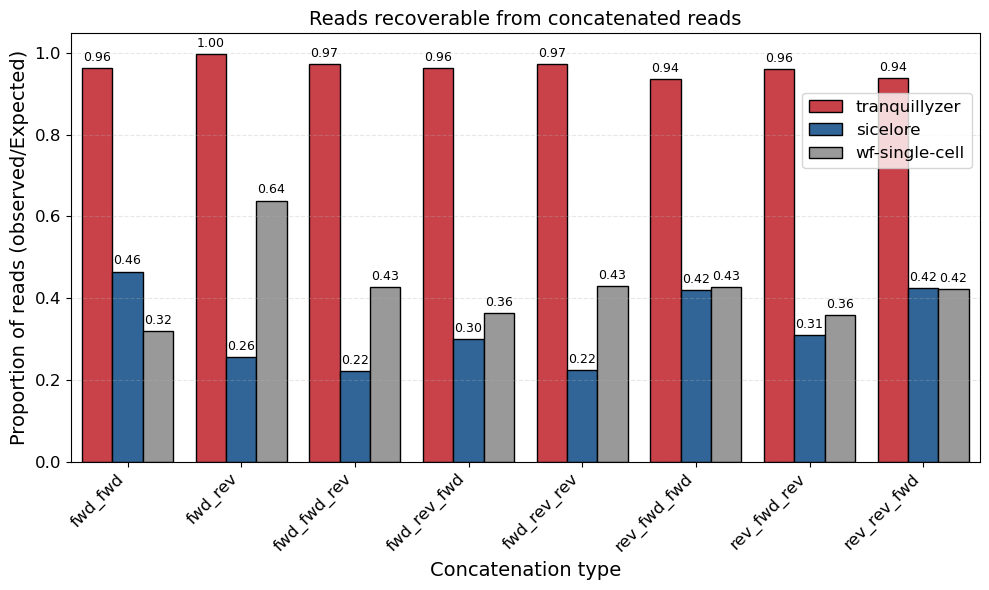

In [7]:
all_tools_total_reads_df_pd = all_tools_total_reads_df.to_pandas()

# Reshape to long format
all_tools_total_reads_plt_df = pd.melt(
    all_tools_total_reads_df_pd,
    id_vars=["type"],
    value_vars=["sicelore_percentage", "tranquillyzer_percentage", "wf-single-cell_percentage"],
    var_name="tool",
    value_name="percentage"
)

# Clean tool names
all_tools_total_reads_plt_df["tool"] = all_tools_total_reads_plt_df["tool"].str.replace("_percentage", "", regex=False)

# Define custom color palette and desired hue order
custom_palette = {
    "tranquillyzer": "#e02b35",
    "sicelore": "#2066a8",
    "wf-single-cell": "#999999"
}
hue_order = ["tranquillyzer", "sicelore", "wf-single-cell"]

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=all_tools_total_reads_plt_df,
    x="type",
    y="percentage",
    hue="tool",
    hue_order=hue_order,
    edgecolor="black",
    palette=custom_palette
)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Concatenation type", fontsize=14)
plt.ylabel("Proportion of reads (observed/Expected)", fontsize=14)
plt.title("Reads recoverable from concatenated reads", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend(title_fontsize=12, fontsize=12, loc='upper right', bbox_to_anchor=(1, 0.88))

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=9, padding=3)

plt.tight_layout()

# Save
plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure2/concatenated_reads.png", dpi=300, bbox_inches='tight')
plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure2/concatenated_reads.svg", bbox_inches='tight')
plt.savefig("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/figures/figure2/concatenated_reads.pdf", bbox_inches='tight')

plt.show()


In [8]:
## Since scNanoGPS doesn't split the reads, plot their valid/invalid rates

scNanoGPS_read_stats = pl.read_csv("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/nreads_scnanogps.txt", separator="\t")
scNanoGPS_invalid_read_stats = scNanoGPS_read_stats.filter(pl.col("dataset").is_in(invalid_types))
scNanoGPS_invalid_read_stats


dataset,n_reads_correct_architecture,n_reads_assigned_corrected_CB
str,i64,i64
"""concat_2x""",99662,65353
"""concat_2x_rev_comp""",99828,29853
"""concat_3x""",101082,60935
"""fwd_fwd_rev""",100630,30256
"""fwd_rev_fwd""",98918,63862
"""fwd_rev_rev""",100048,29692
"""rev_fwd_fwd""",8,0
"""rev_fwd_rev""",101696,101696
"""rev_rev_fwd""",16,0


In [9]:
## any correlation between reads not passed with sicelore and number of random bases?

import polars as pl
pl.Config.set_tbl_cols(100)

sicelore_5M = pl.read_csv("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/sicelore/benchmarking/benchmark_results/positions.100_500bp_005M.tsv.gz", separator = '\t')
print(sicelore_5M.shape)
tranquillyzer_valid = pl.read_parquet("")

# tranquillyzer_valid = pl.read_parquet("/home/ayush.semwal/shen-secondary/projects/2025_03_12_tranquilizer_benchmarking/tranquilizer/simulated/10x3p_sc/100_500bp/5_mil/CRF/annotations_valid.parquet")
print(tranquillyzer_valid.filter(~tranquillyzer_valid["ReadName"].is_in(sicelore_5M["name"])).tail)
print(tranquillyzer_valid.filter(~tranquillyzer_valid["ReadName"].is_in(sicelore_5M["name"])).filter(pl.col("polyA_Starts") != "null").shape)



(3223958, 8)


FileNotFoundError: No such file or directory (os error 2): 

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'sink'


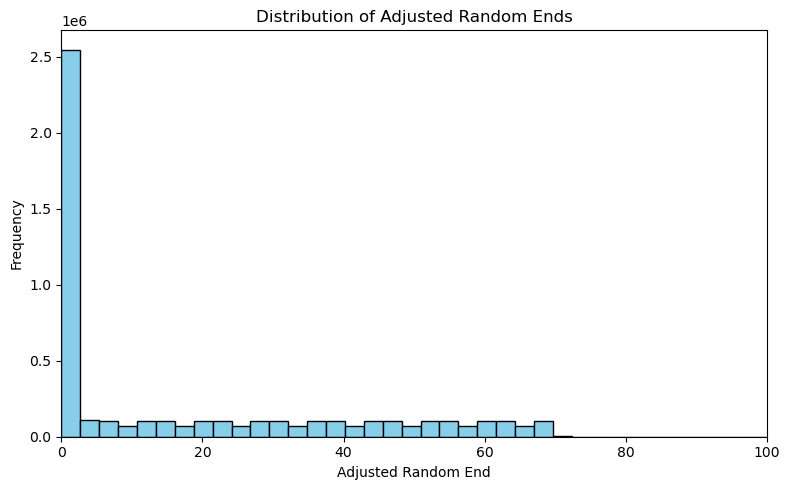

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Filter out nulls
df = tranquillyzer_valid.filter(
    (pl.col("random_s_Starts") != "null") & (pl.col("random_s_Ends") != "null")
)

# Convert to numeric
df = df.with_columns([
    pl.col("random_s_Starts").cast(pl.Int64),
    pl.col("random_s_Ends").cast(pl.Int64),
    pl.col("read_length").cast(pl.Int64)
])

# Step 2 & 3: Compute adjusted values
adjusted_random_ends = df.with_columns(
    pl.when(pl.col("random_s_Starts") == 0)
      .then(pl.col("random_s_Ends"))
      .otherwise(pl.col("read_length") - pl.col("random_s_Ends"))
      .alias("adjusted_random_end")
)["adjusted_random_end"]

# Step 4: Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(adjusted_random_ends.to_list(), bins=100, color="skyblue", edgecolor="black")
plt.xlabel("Adjusted Random End")
plt.xlim(0,100)
plt.ylabel("Frequency")
plt.title("Distribution of Adjusted Random Ends")
plt.tight_layout()
plt.show()